In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib
import PIL

import tensorflow as tf
from tensorflow.keras import layers

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))

In [3]:
roses = list(data_dir.glob('roses/*'))

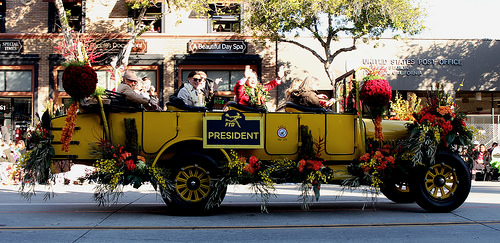

In [4]:
PIL.Image.open(str(roses[0]))

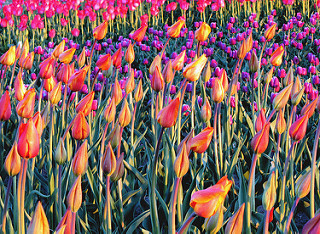

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [6]:
tf.keras.preprocessing.image_dataset_from_directory?

In [7]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names

In [14]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

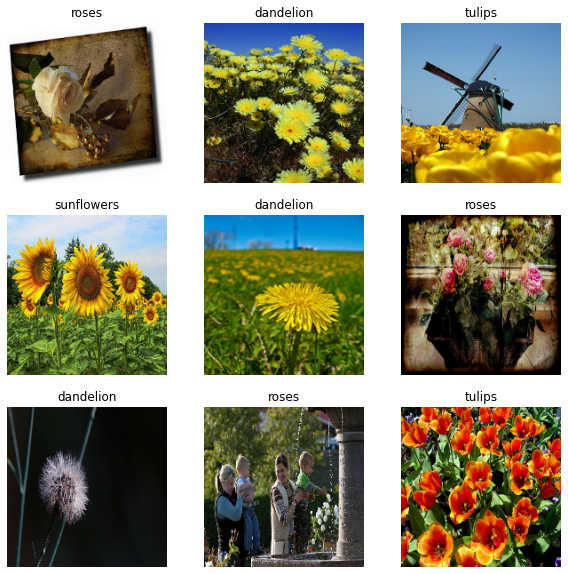

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# Standardize the data
# RGB channel values are in [0, 255] -> standardize values to be [0, 1]
from tensorflow.keras import layers

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [25]:
normalization_layer

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [29]:
import numpy as np
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

(0.0, 0.97046)

In [35]:
# Create the model
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [39]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 37s 392ms/step - loss: 1.3772 - accuracy: 0.4059 - val_loss: 1.0444 - val_accuracy: 0.6063
Epoch 2/10
92/92 [==============================] - 33s 359ms/step - loss: 0.9505 - accuracy: 0.6366 - val_loss: 0.9489 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 61s 668ms/step - loss: 0.7429 - accuracy: 0.7154 - val_loss: 0.8820 - val_accuracy: 0.6649
Epoch 4/10
92/92 [==============================] - 42s 460ms/step - loss: 0.5278 - accuracy: 0.8030 - val_loss: 1.0877 - val_accuracy: 0.6226
Epoch 5/10
92/92 [==============================] - 46s 501ms/step - loss: 0.3241 - accuracy: 0.8893 - val_loss: 1.0732 - val_accuracy: 0.6580
Epoch 6/10
92/92 [==============================] - 45s 489ms/step - loss: 0.1607 - accuracy: 0.9509 - val_loss: 1.1471 - val_accuracy: 0.6717
Epoch 7/10
92/92 [==============================] - 43s 462ms/step - loss: 0.0725 - accuracy: 0.9811 - val_loss: 1.2068 - val_accuracy: 0.6676

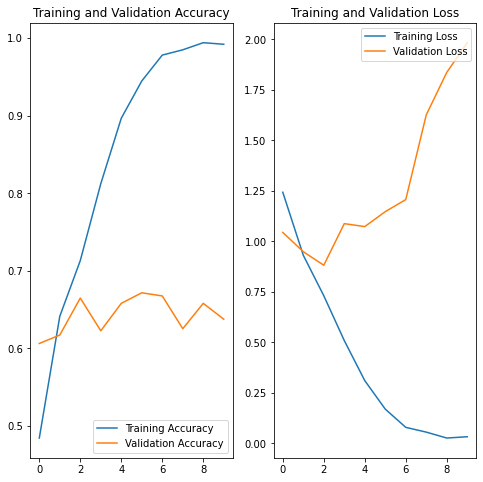

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [44]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

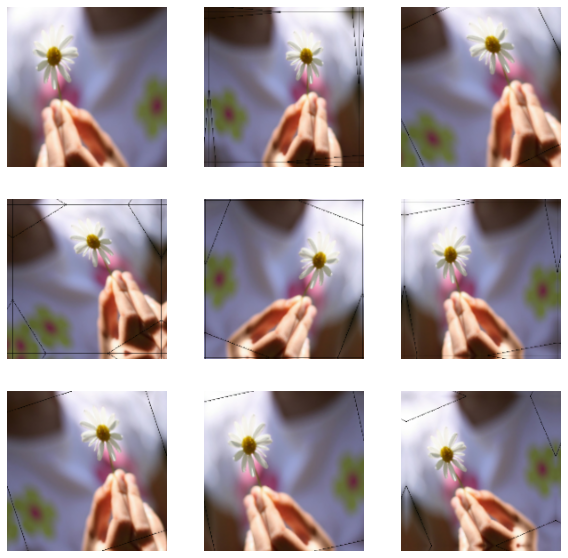

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [46]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [50]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 41s 440ms/step - loss: 1.5285 - accuracy: 0.3292 - val_loss: 1.0625 - val_accuracy: 0.5681
Epoch 2/15
92/92 [==============================] - 42s 462ms/step - loss: 1.0488 - accuracy: 0.5931 - val_loss: 1.0415 - val_accuracy: 0.5831
Epoch 3/15
92/92 [==============================] - 75s 811ms/step - loss: 0.9541 - accuracy: 0.6244 - val_loss: 0.9165 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 50s 538ms/step - loss: 0.9019 - accuracy: 0.6465 - val_loss: 0.9475 - val_accuracy: 0.6213
Epoch 5/15
92/92 [==============================] - 56s 605ms/step - loss: 0.8302 - accuracy: 0.6704 - val_loss: 0.8403 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 52s 564ms/step - loss: 0.7479 - accuracy: 0.7132 - val_loss: 0.7901 - val_accuracy: 0.6853
Epoch 7/15
92/92 [==============================] - 58s 631ms/step - loss: 0.7111 - accuracy: 0.7342 - val_loss: 0.8156 - val_accuracy: 0.6785

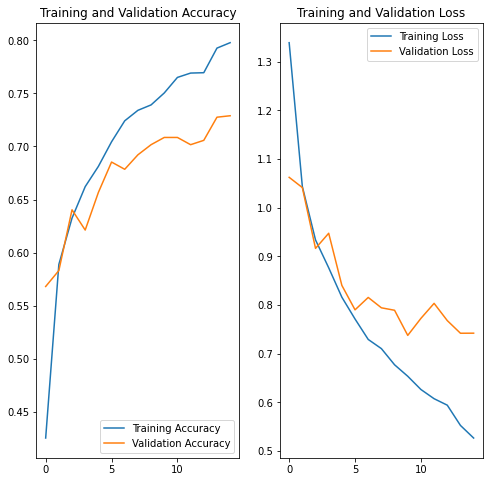

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [52]:
# cifar10 images
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [53]:
filepath = './cifar-10-batches-py/data_batch_1'

In [54]:
cifar_images = unpickle(filepath)

In [55]:
cifar_images

{b'batch_label': b'training batch 1 of 5',
 b'labels': [6,
  9,
  9,
  4,
  1,
  1,
  2,
  7,
  8,
  3,
  4,
  7,
  7,
  2,
  9,
  9,
  9,
  3,
  2,
  6,
  4,
  3,
  6,
  6,
  2,
  6,
  3,
  5,
  4,
  0,
  0,
  9,
  1,
  3,
  4,
  0,
  3,
  7,
  3,
  3,
  5,
  2,
  2,
  7,
  1,
  1,
  1,
  2,
  2,
  0,
  9,
  5,
  7,
  9,
  2,
  2,
  5,
  2,
  4,
  3,
  1,
  1,
  8,
  2,
  1,
  1,
  4,
  9,
  7,
  8,
  5,
  9,
  6,
  7,
  3,
  1,
  9,
  0,
  3,
  1,
  3,
  5,
  4,
  5,
  7,
  7,
  4,
  7,
  9,
  4,
  2,
  3,
  8,
  0,
  1,
  6,
  1,
  1,
  4,
  1,
  8,
  3,
  9,
  6,
  6,
  1,
  8,
  5,
  2,
  9,
  9,
  8,
  1,
  7,
  7,
  0,
  0,
  6,
  9,
  1,
  2,
  2,
  9,
  2,
  6,
  6,
  1,
  9,
  5,
  0,
  4,
  7,
  6,
  7,
  1,
  8,
  1,
  1,
  2,
  8,
  1,
  3,
  3,
  6,
  2,
  4,
  9,
  9,
  5,
  4,
  3,
  6,
  7,
  4,
  6,
  8,
  5,
  5,
  4,
  3,
  1,
  8,
  4,
  7,
  6,
  0,
  9,
  5,
  1,
  3,
  8,
  2,
  7,
  5,
  3,
  4,
  1,
  5,
  7,
  0,
  4,
  7,
  5,
  5,
  1,
  0,
  9,
  6,
  9,
 

In [71]:
cifar_100_ds = tfds.load('cifar100')

In [83]:
d = tfds.image_classification.Cifar100()

In [86]:
d.data_dir

'/Users/seulchankim/tensorflow_datasets/cifar100/3.0.2'

In [87]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

10000

In [91]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [94]:
# cifar 10-1
# https://www.cs.toronto.edu/%7Ekriz/cifar.html

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [145]:
ds = tfds.load('cifar10', as_supervised=True)
cifar_train, cifar_test = ds['train'], ds['test']

In [139]:
cifar_train

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

In [146]:
cifar_train[0]

TypeError: 'PrefetchDataset' object does not support indexing

In [180]:
# CIFAR10
from tensorflow.keras import datasets
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [181]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [182]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

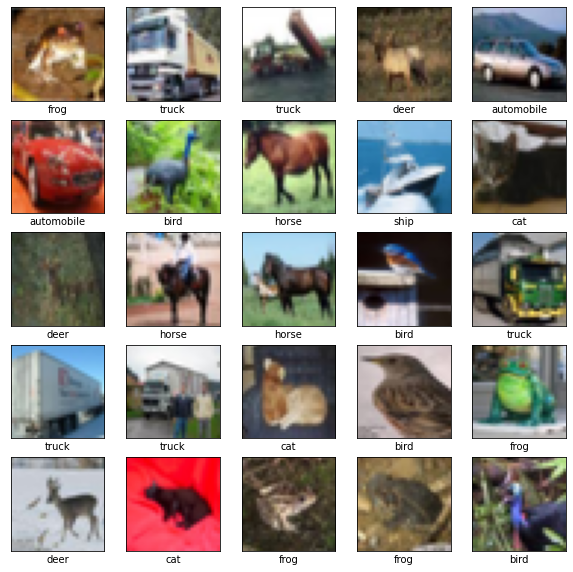

In [183]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [184]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [158]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [185]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [187]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [188]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10


ValueError: in user code:

    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:777 train_function  *
        return step_function(self, iterator)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:767 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1261 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2794 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3217 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:760 run_step  **
        outputs = model.train_step(data)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:726 train_step
        y_pred = self(x, training=True)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:977 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/seulchankim/.pyenv/versions/3.6.8/envs/ml-tutorial/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, 32, 32, 3)
